## 1. 加载数据
可以看到 IMDB_Dataset 的加载结果是一个 (50000, 2) 形状的 DataFrame。一共 50000 个样本，每个样本占一行，包含两列 ———— 第 0 列为 review，第 1 列为 sentiment。

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

current_working_directory = os.getcwd()
csv_path = os.path.join(current_working_directory, 'IMDB_Dataset.csv')
df = pd.read_csv(csv_path)

# 查看数据信息
print("数据前5行:")
print(df.head())
print("\n数据信息:")
df.info()

数据前5行:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## 2. 数据规范化
注意到样本的 sentiment 属性为 'positive' / 'negative'，将其映射到 1 / 0 便于处理。 另外，样本的 review 属性为 HTML 格式，需要进行去除 HTML 标签，大写字母全部改为小写等操作，将文本格式统一。

In [2]:
# 将 'positive'/'negative' 转换为 1/0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    # 去除HTML标签
    text = re.sub(r'<.*?>', '', text)
    # 只保留字母和空格
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # 全部转换为小写
    text = text.lower()
    # 去除多余的空格
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)
print("\n文本清洗效果:")
print(df[['review', 'cleaned_review']].head())


文本清洗效果:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti...  
3  basically theres a family where a little boy j...  
4  petter matteis love in the time of money is a ...  


## 3. 加载训练、验证数据
先实例化一个分词器，分词器会先浏览所有规范化后的 review，统计每个词的出现频率，据此给词汇表中的每一个词分配一个序号表示这个词的重要程度（相当于创建了一个 dict），然后根据这个 dict 将每个 review 从词的序列映射到整数的序列。

In [3]:
x = df['cleaned_review']
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

# 定义超参数
vocab_size = 15000  # 词典中最大单词数
max_len = 200       # 每条评论的最大长度
embedding_dim = [16, 32, 64]  # 词向量维度

# 创建一个分词器
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# 使用分词器将 review（词的序列）转换为整数的序列便于处理
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# 统一所有样本的序列长度为 max_len，若长度不足，填充 0；若长度超过，则截断
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')
print(f"\n填充后的训练数据形状: {x_train_pad.shape}")
print(f"填充后的测试数据形状: {x_test_pad.shape}")


填充后的训练数据形状: (35000, 200)
填充后的测试数据形状: (15000, 200)


## 4. 尝试使用 SVM 进行预测
由于输入是文本，输出是文本的情感，变量之间的关系较复杂，在传统机器学习算法中选用 SVM 较为合适。在具体实现上，我先是使用 `svm = SVC(kernel='linear', C=1.0) ` 来实例化模型并训练，但是速度非常慢，因为 SVM 的时间复杂度在 $O(n^2) \sim O(n^3)$ 之间，在这里 n 大于 10000。所以改为使用随机梯度下降求得近似解 `svm = SGDClassifier(loss='hinge', max_iter=20, tol=1e-3)`。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1,1),
    max_df=0.8,
    min_df=10
)
x_tr = tfidf.fit_transform(x_train)
x_te = tfidf.transform(x_test)

svm = SGDClassifier(loss='hinge', max_iter=20, tol=1e-3)
svm.fit(x_tr, y_train)

y_pred = svm.predict(x_te)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8760666666666667


## 5. 模型训练并实验不同 embedding_dim 取值对模型预测准确性的影响
这里构建了一个简单的 LSTM 网络，大致构造思路如下。在之前的步骤中，我将一个 review 字符串转化为了一个词序号的序列，如：`[5, 1, 7, 3, 6, ...]`。现在，我将这个序列作为模型的输入，希望输出一个值，表示文本情感的预测结果。

然而，这种词序号的表示方式只能大致描述一下词的重要程度，但是对词意的把握并不精准，所以先添加一层 Embedding 层，将每一个词序号映射到一个 64 维的语义空间中，该层的输出为一个矩阵，具体的映射函数由训练过程习得。

有了上一层输出的矩阵，模型就能知道：输入字符串是由哪些词组成的；它们各自的含义是什么。但是，并不是很好的理解句子中的每一个词就能很好的理解句意的，理解句子需要联系上下文判断每个词的含义（如:"虽然..., 但是..."类型的句子），所以需要添加 LSTM 层。 这里添加了两层是因为感觉一层 LSTM 无法很好的捕捉所有的信息。

之后再引入一层 Dropout 层是因为查阅资料时有提到过 LSTM 参数过多，可能会记住一些噪声，影响评估新样本时的性能，所以让网络随机忽略一半的单元，使得网络学习到的规律更具有普适性。

最后，添加一个全连接层来把提炼出来的高层次特征进行组合，再把它送进只有一个神经元的输出层，使用 Sigmoid 激活函数，把结果压缩到 0～1 之间，作为最终的输出。


词向量维度: 16
Epoch 1/5
547/547 [==============================] - 22s 34ms/step - loss: 0.4263 - accuracy: 0.7923 - val_loss: 0.3122 - val_accuracy: 0.8675
Epoch 2/5
547/547 [==============================] - 18s 32ms/step - loss: 0.2560 - accuracy: 0.9030 - val_loss: 0.3374 - val_accuracy: 0.8680
Epoch 3/5
547/547 [==============================] - 17s 32ms/step - loss: 0.1869 - accuracy: 0.9333 - val_loss: 0.3458 - val_accuracy: 0.8589
Epoch 4/5
547/547 [==============================] - 17s 32ms/step - loss: 0.1388 - accuracy: 0.9537 - val_loss: 0.4191 - val_accuracy: 0.8592
Epoch 5/5
547/547 [==============================] - 16s 28ms/step - loss: 0.1096 - accuracy: 0.9633 - val_loss: 0.4100 - val_accuracy: 0.8457

词向量维度: 32
Epoch 1/5
547/547 [==============================] - 22s 32ms/step - loss: 0.4276 - accuracy: 0.7935 - val_loss: 0.3110 - val_accuracy: 0.8679
Epoch 2/5
547/547 [==============================] - 18s 32ms/step - loss: 0.2475 - accuracy: 0.9078 - val_loss: 0.3520 

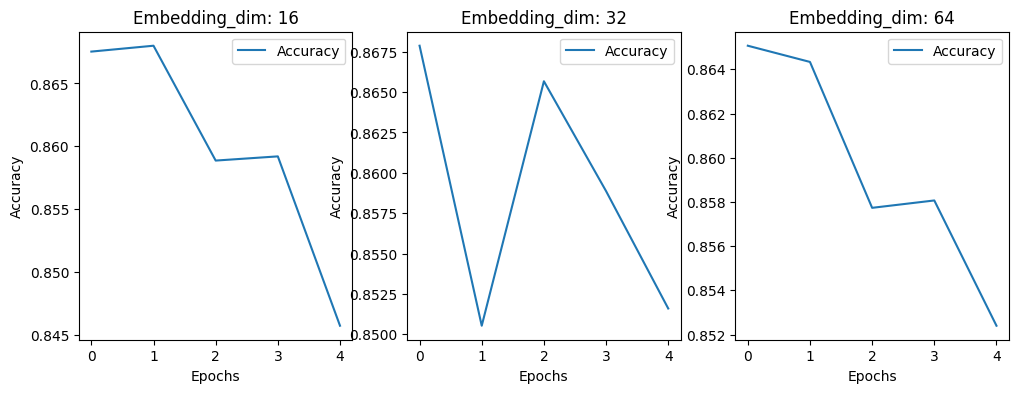

In [8]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False
accuracy = []
plt.figure(figsize=(12, 4))
for i in range(len(embedding_dim)):
    dim = embedding_dim[i]
    print(f"\n词向量维度: {dim}")

    model = Sequential([
        # 嵌入层
        Embedding(input_dim=vocab_size, output_dim=dim, input_length=max_len),
        
        # 双向LSTM (Bidirectional LSTM)层
        Bidirectional(LSTM(units=32, return_sequences=True)),
        
        # 再添加一个LSTM层
        Bidirectional(LSTM(units=24)),
        
        # 添加Dropout层防止过拟合
        Dropout(0.5),
        
        # 全连接层
        Dense(units=32, activation='relu'),
        
        # 输出层
        Dense(units=1, activation='sigmoid')
    ])

    # 编译模型，使用adam作为优化器，二元交叉熵作为损失函数
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 定义超参数
    epoch = 5
    batch_size = 64  # 尝试不同的批次大小
    # 训练模型
    history = model.fit(
        x_train_pad, y_train,
        epochs=epoch,
        batch_size=batch_size,
        validation_data=(x_test_pad, y_test),
        verbose=1
    )
    accuracy.append(history.history['val_accuracy'][-1])
    plt.subplot(1, 3, i + 1)
    plt.plot(history.history['val_accuracy'], label='Accuracy')
    plt.title('Embedding_dim: {}'.format(dim))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
        
print("\n模型训练完成!")
plt.show()

下图展示的是对于不同 Embedding_dim(16, 32, 64) 的取值对模型准确度的影响。因为当前的二分类任务可能较简单，不对语义空间的维数有较高要求，所以在使用不同 Embedding_dim 时，模型准确度虽有差异但不明显。

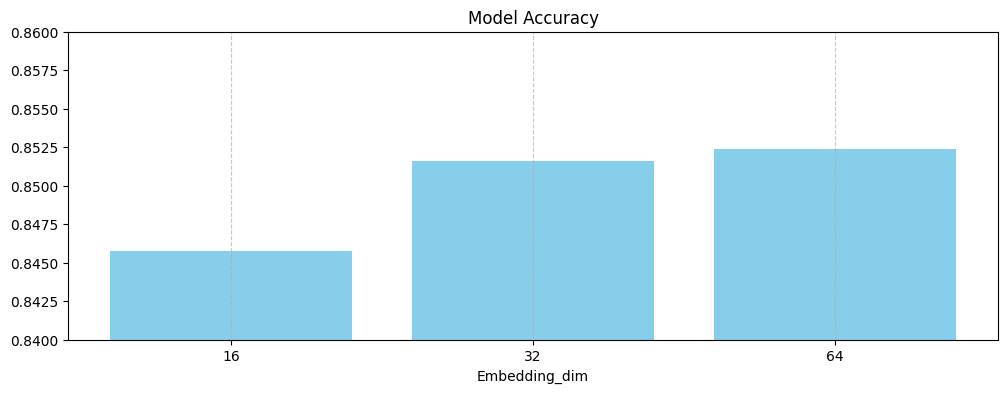

In [9]:
names = ['16', '32', '64']
plt.figure(figsize=(12, 4))
plt.bar(names, accuracy, color=['skyblue'])
plt.xlabel('Embedding_dim')
plt.title('Model Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 3, 1))
plt.ylim(0.84, 0.86)
plt.show()

## 6. 模型训练与调参
这一部分对模型各个超参数进行详细调整测试以寻找最优参数配置。首先，自定义一个 RandomSearch 搜索器进行搜索 embedding_dim 的值可以为 `16, 32, 48, ···, 128`; 第二，三层的 LSTM 的单元数可以为 32 或 64; dropout 可以为 `0.2, 0.3, ···, 0.6`;学习率可以为 $10^{-4} \sim 10^{-2}$ 之间，均匀采样。在进行某组参数的测试时，每次最多跑 10 轮，并且启用早停机制 ———— 当测试集的损失 `val_loss` 连续 3 轮不下降时自动停止当前训练。可以看到进行调参之后的模型准确率为87.6%，高于之前未调参的模型。

In [ ]:
from keras import layers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = keras.Sequential()
    # Embedding 层
    emb_dim = hp.Int('embedding_dim', min_value=16, max_value=128, step=16)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
    
    # LSTM 层
    units = hp.Choice('lstm_units', [32, 64])
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(units)))
    
    # Dropout 层
    rate = hp.Float('dropout_rate', 0.2, 0.6, step=0.1)
    model.add(layers.Dropout(rate))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 学习率调整
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 配置 RandomSearch 搜索器
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,           # 总共尝试20种超参数组合
    executions_per_trial=1,  # 每组参数只训练一次
    directory='tuner_dir',
    project_name='imdb_bilstm'
)

# 引入早停机制并开始训练
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(
    x_train_pad, y_train,
    epochs=10,
    validation_data=(x_test_pad, y_test),
    callbacks=[stop_early],
    verbose=1
)

# 输出最佳超参数与对应性能
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"最佳 embedding_dim：{best_hp.get('embedding_dim')}")
print(f"最佳 lstm_units：{best_hp.get('lstm_units')}")
print(f"最佳 dropout_rate：{best_hp.get('dropout_rate')}")
print(f"最佳 learning_rate：{best_hp.get('learning_rate')}")

Trial 20 Complete [00h 02m 52s]
val_accuracy: 0.8650000095367432

Best val_accuracy So Far: 0.8758000135421753
Total elapsed time: 00h 57m 13s
最佳 embedding_dim：96
最佳 lstm_units：64
最佳 dropout_rate：0.2
最佳 learning_rate：0.0016483993178203354


## 7. 总结
在本次影评情感分类任务中，我先后构建了多种模型进行情感分类：包括基于 TF-IDF 的线性 SVM （通过随机梯度下降来求得近似解）、双向 LSTM 网络，并通过 Keras Tuner 来实现自动调参。实验结果表明，简单的 TF-IDF + LinearSVC 模型虽然从原理上来说，在处理长距离语义依赖时该方法效率有限，但是能够在不到十秒的时间内取得近 87.6% 的准确率。相比之下，双向 LSTM 网络能更全面地捕捉句子中前后文的情感线索，经过调参之后，最终准确率也在 87.6%左右，但是可能在某些特殊的样本上表现更好。

其中，在自动调参部分，我让程序在嵌入层维度、LSTM 单元数、Dropout 比例和学习率不同取值下进行模型训练、预测，最终找到的最佳组合为：
```text
最佳 embedding_dim：96
最佳 lstm_units：64
最佳 dropout_rate：0.2
最佳 learning_rate：0.0016483993178203354
```
与最初手动设置的基线模型相比，这次微调带来了近 1.3% 的提升。

综合来看，TF-IDF + SVM 的预测模型训练速度快且对该类任务的解释性不弱，适合在训练资源紧张或需要快速部署的场景中作为首选方案；双向 LSTM 则在上下文理解方面具有优势，尤其适合复杂句式或暗示的文本情感分类任务，但是需要合适的模型结构和参数设置。对此可以使用 Keras Tuner 的自动搜索，节约人工调参时间，并使模型在稳定性和泛化能力上获得提升，但是仍然对资源要求较高且训练速度慢。
